In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px #piechart için px
import missingno as msno

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Importing ML Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import precision_score, confusion_matrix

from sklearn import tree

import warnings
warnings.filterwarnings('always')

In [ ]:
# Required Functions
def show_distributions(columns: list, data: pd.DataFrame, nrows: int = 1, ncols: int = 3):
    # This function creates distribution subplots.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        sns.histplot(data[column], kde=True, ax=axes[index])
        axes[index].set_title(column)

        # Adjust layout
    plt.tight_layout()
    plt.show()

def show_boxplots(columns: list, data: pd.DataFrame, nrows: int = 3, ncols: int = 3):
    # This function creates box plot subplots.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        axes[index].boxplot(data[column])
        axes[index].set_title(column)

    plt.tight_layout()
    plt.show()

def normality_test(columns: list, data: pd.DataFrame):
    # Conducts Shapiro-Wilk test.
    for i in columns:
        results = shapiro(data[data[i].isna() == False][i])
        print(i, results.statistic)

def random_sample_imputation(df):
    # Random Sample Imputatuin
    cols_with_missing_values = df.columns[df.isna().any()].tolist()

    for var in cols_with_missing_values:

        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(),
                                                      random_state=0)
        random_sample_df.index = df[
                df[var].isnull()].index

        df.loc[df[var].isnull(), var] = random_sample_df

    return df

def visualize_isolation_forest(columns: list, data: pd.DataFrame, contamination: list,nrows: int = 2, ncols: int = 3,):
    # Visualize resuls from different contamination values
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, i in enumerate(contamination):
        model = IsolationForest(contamination=i)  # Adjust the contamination parameter
        model.fit(data.to_numpy())
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == -1], x = columns[0], y = columns[1], color='blue', label='Outlier', ax = axes[index])
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == 1], x = columns[0], y = columns[1], color='red', label='Normal', ax = axes[index])
        axes[index].legend()
        axes[index].set_title(f"Contamination Value: {round(i,3)}")
    plt.show()

def remove_outliers(data: pd.DataFrame, contamination: int):
    # Apply Isolation Forest
    model = IsolationForest(contamination = contamination)
    model.fit(data.to_numpy())
    return data[model.predict(data.to_numpy()) == 1]

def roc_plot(models: list, X_test: pd.DataFrame, y_test: pd.DataFrame):
    # Create ROC plot for multiple models.]
    plt.figure(figsize=(20,10))
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    for model in models:
        lr_probs = model.predict_proba(X_test)
        lr_probs = lr_probs[:, 1]
        lr_auc = roc_auc_score(y_test, lr_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        plt.plot(lr_fpr, lr_tpr, marker='.', label = model["classifier"])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def forest_feature_importance(model,X_test):
    # Visualize Random Forest Feature Importance
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def forest_permutation_importance(model, X_test, y_test, n_repeats:int = 10):
    # Visualize Random Forest Permutation Importance
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    result = permutation_importance(
        model, X_test.to_numpy(), y_test, n_repeats=n_repeats, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(importances, index = feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.read_csv("water_potability.csv", encoding= 'unicode_escape')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
df.describe(percentiles=[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]).T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,0%,1%,5%,10%,25%,50%,75%,90%,95%,99%,100%,max
ph,2785.0,7.080795,1.594320,0.000000,0.000000,3.406797,4.487971,5.106286,6.093092,7.036752,8.062066,9.078356,9.789819,10.895339,14.000000,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,47.432000,114.236366,141.763281,155.223964,176.850538,196.967627,216.667456,236.350707,249.609769,278.062602,323.124000,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,320.942611,5416.238724,9545.812579,11740.528189,15666.690297,20927.833607,27332.762127,33814.935230,38474.990249,45974.106490,61227.196008,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,0.352000,3.203082,4.503054,5.181271,6.127421,7.130299,8.114887,9.122578,9.753101,10.967153,13.127000,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,129.000000,232.499338,266.616232,283.147302,307.699498,333.073546,359.950170,385.966882,403.070190,434.021991,481.030642,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,181.483754,269.422947,300.109466,325.117124,365.734414,421.884968,481.792304,533.297241,566.349320,617.626558,753.342620,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,2.200000,6.452487,8.815362,10.123765,12.065801,14.218338,16.557652,18.504567,19.637254,22.090049,28.300000,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,0.738000,27.759075,39.552928,45.845615,55.844536,66.622485,77.337473,86.491600,92.124059,104.739231,124.000000,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,1.450000,2.161414,2.684279,2.951803,3.439711,3.955028,4.500320,4.977141,5.220925,5.741640,6.739000,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info(),(len(df))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


(None, 3276)

In [ ]:
cols = df.columns
cols

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

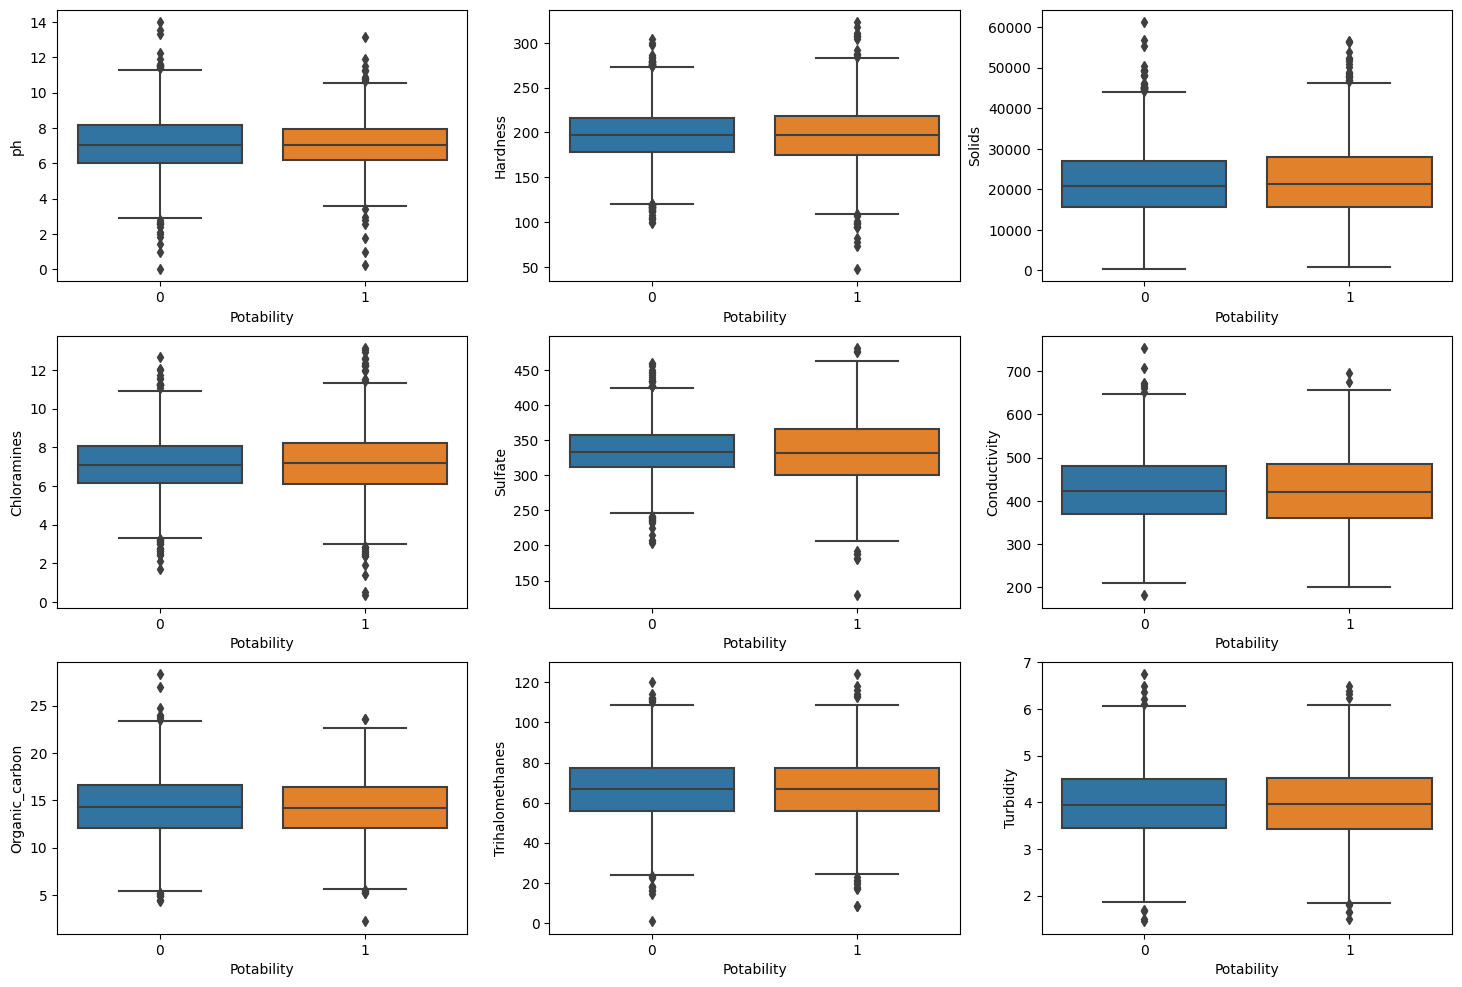

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
plt.figure(figsize=(18,12))
for i,j in zip(cols[:-1], range(len(cols)-1)):
    plt.subplot(3,3,j+1)
    sns.boxplot(x=df.Potability, y=df[i])
plt.show()

Dependent Variable Analysis

In [ ]:
p=df['Potability'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
fig = px.pie(p, values = "Potability", names = ["Not Potable", "Potable"], hole = 0.33, opacity = 0.85,
            labels = {"label" :"Potability","Potability":"Number of Samples"})
fig.update_layout(title = dict(text = "Pie Chart of Potability Feature"))
fig.update_traces(textposition = "outside", textinfo = "percent+label")
fig.show()

Streaming output truncated to the last 5000 lines.
<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHoo

Correlation Between Features

In [ ]:
df.corr()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarnin

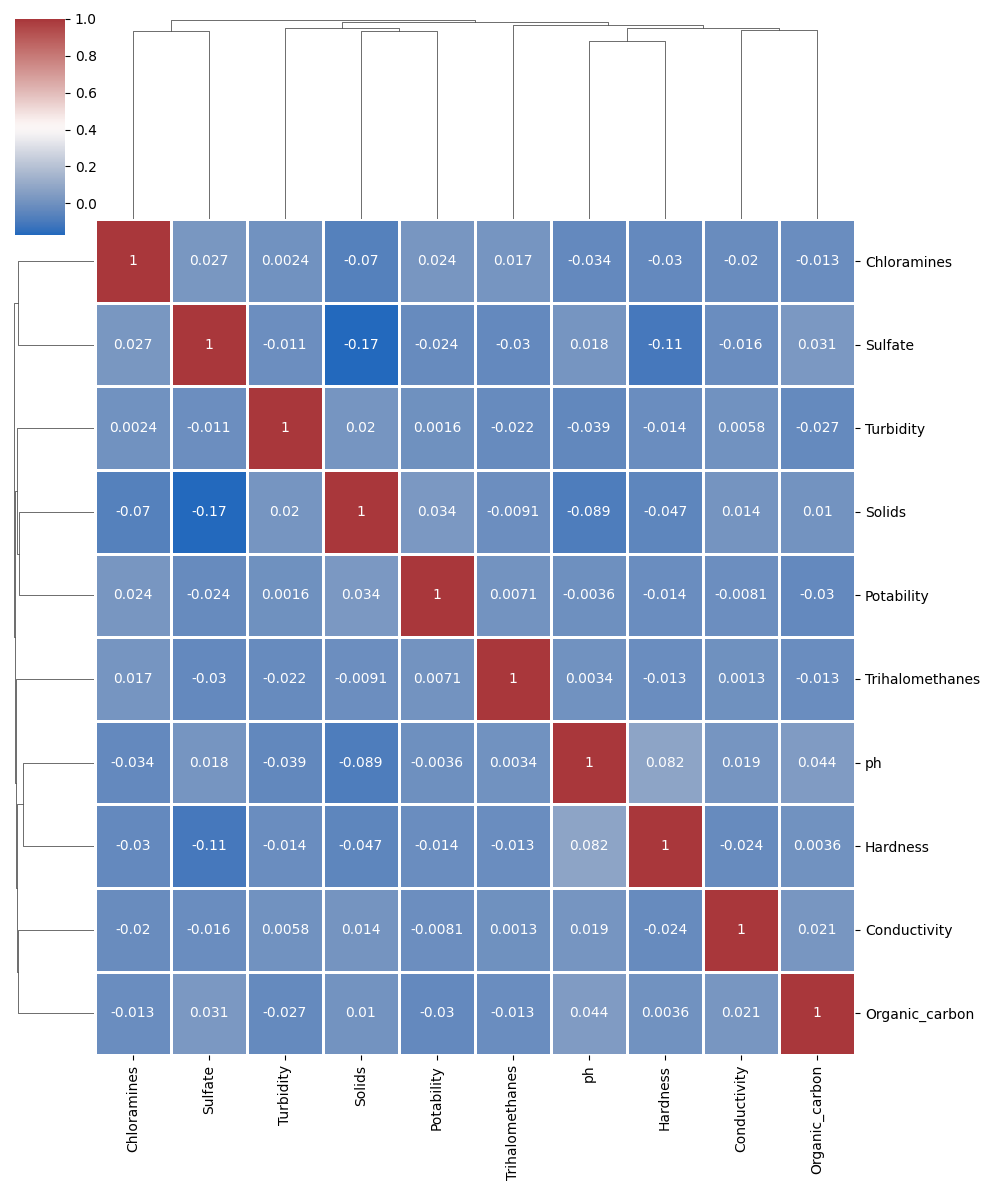

In [ ]:
sns.clustermap(df.corr(),cmap="vlag",dendrogram_ratio=(0.1,0.2),\
              annot = True, linewidths = 1, figsize=(10,12))
plt.show();

Distubituion of Features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



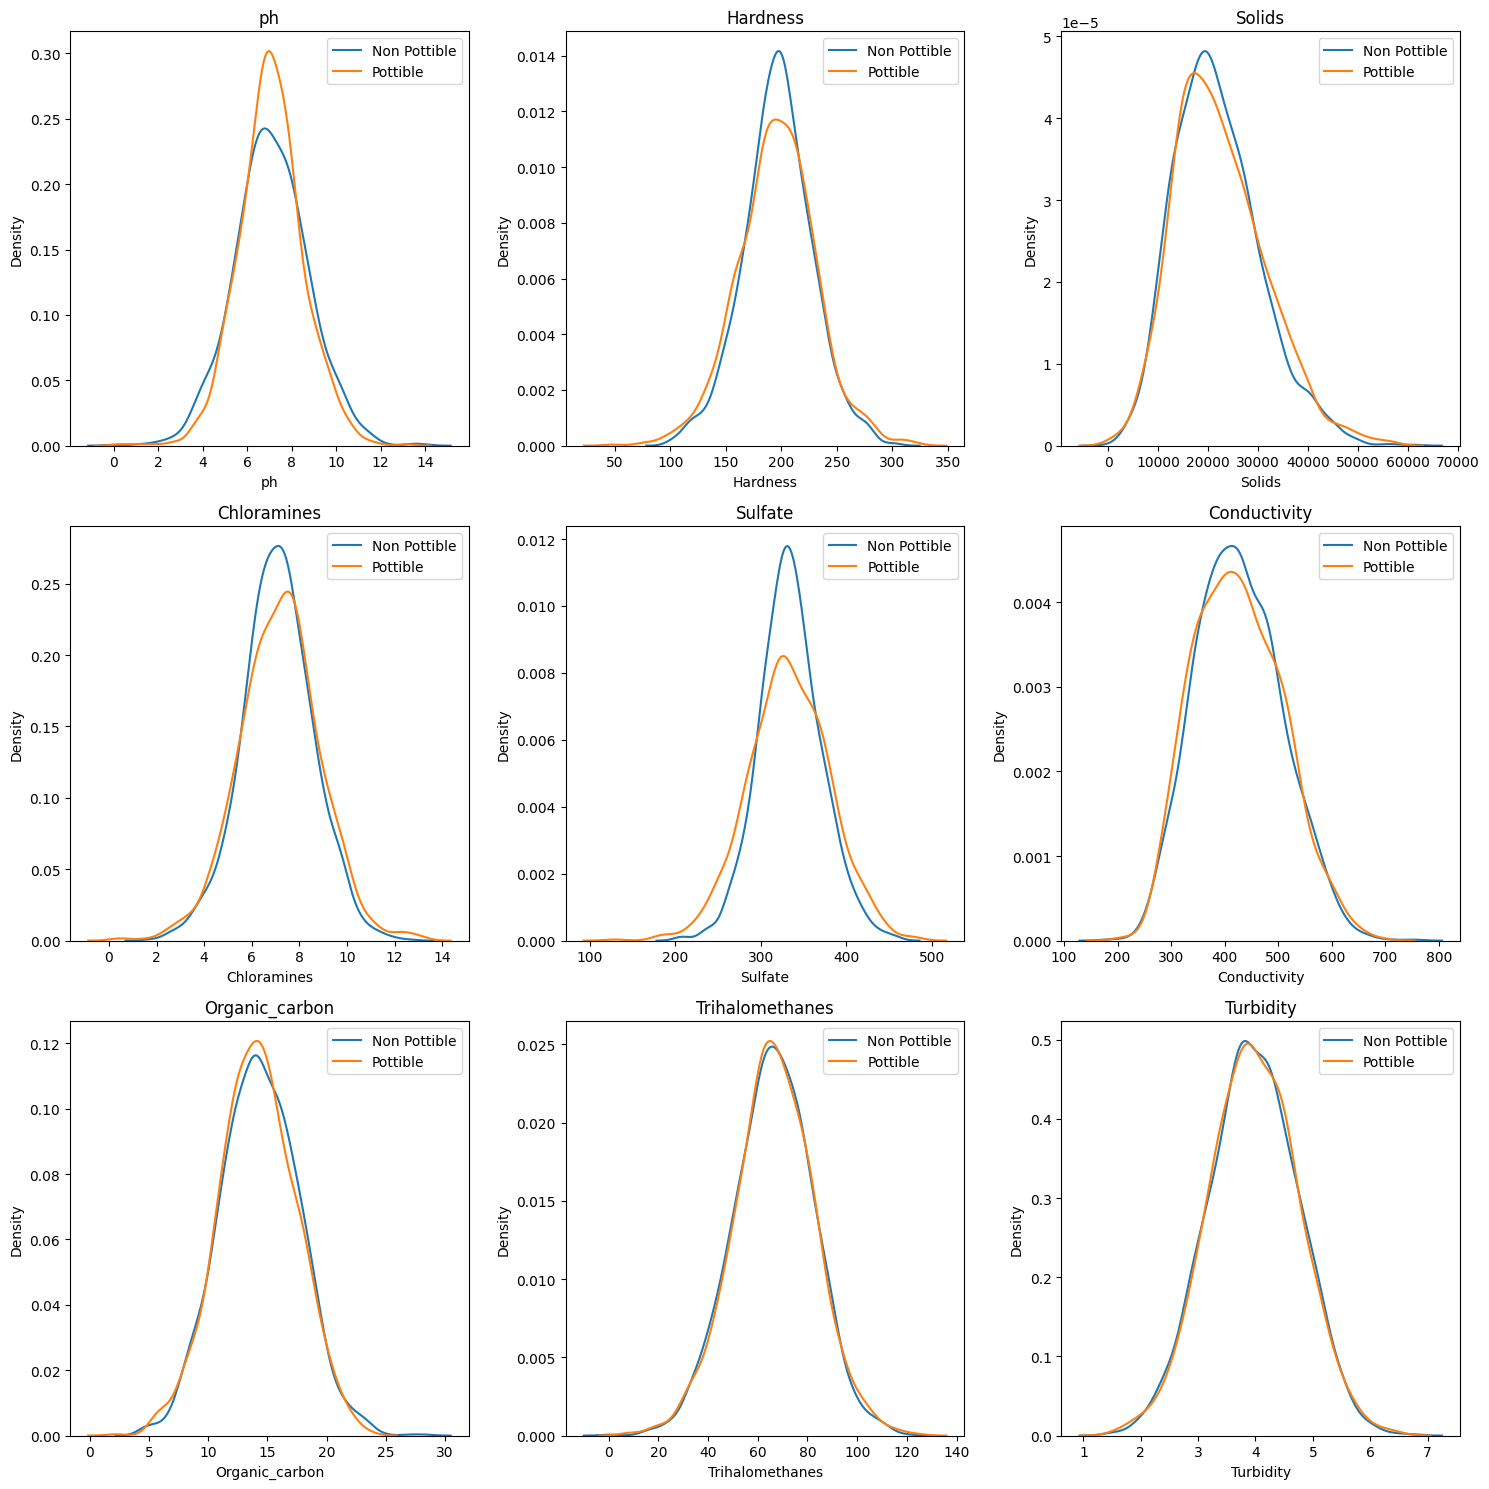

In [ ]:
non_pottible = df[df['Potability'] == 0]
pottible = df[df['Potability'] == 1]

plt.figure(figsize=(15,15))

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(col)
    sns.kdeplot(x=non_pottible[col],label = "Non Pottible")
    sns.kdeplot(x=pottible[col],label = "Pottible")
    plt.legend()

plt.tight_layout()

Preprocessing: Missing Value Problem

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



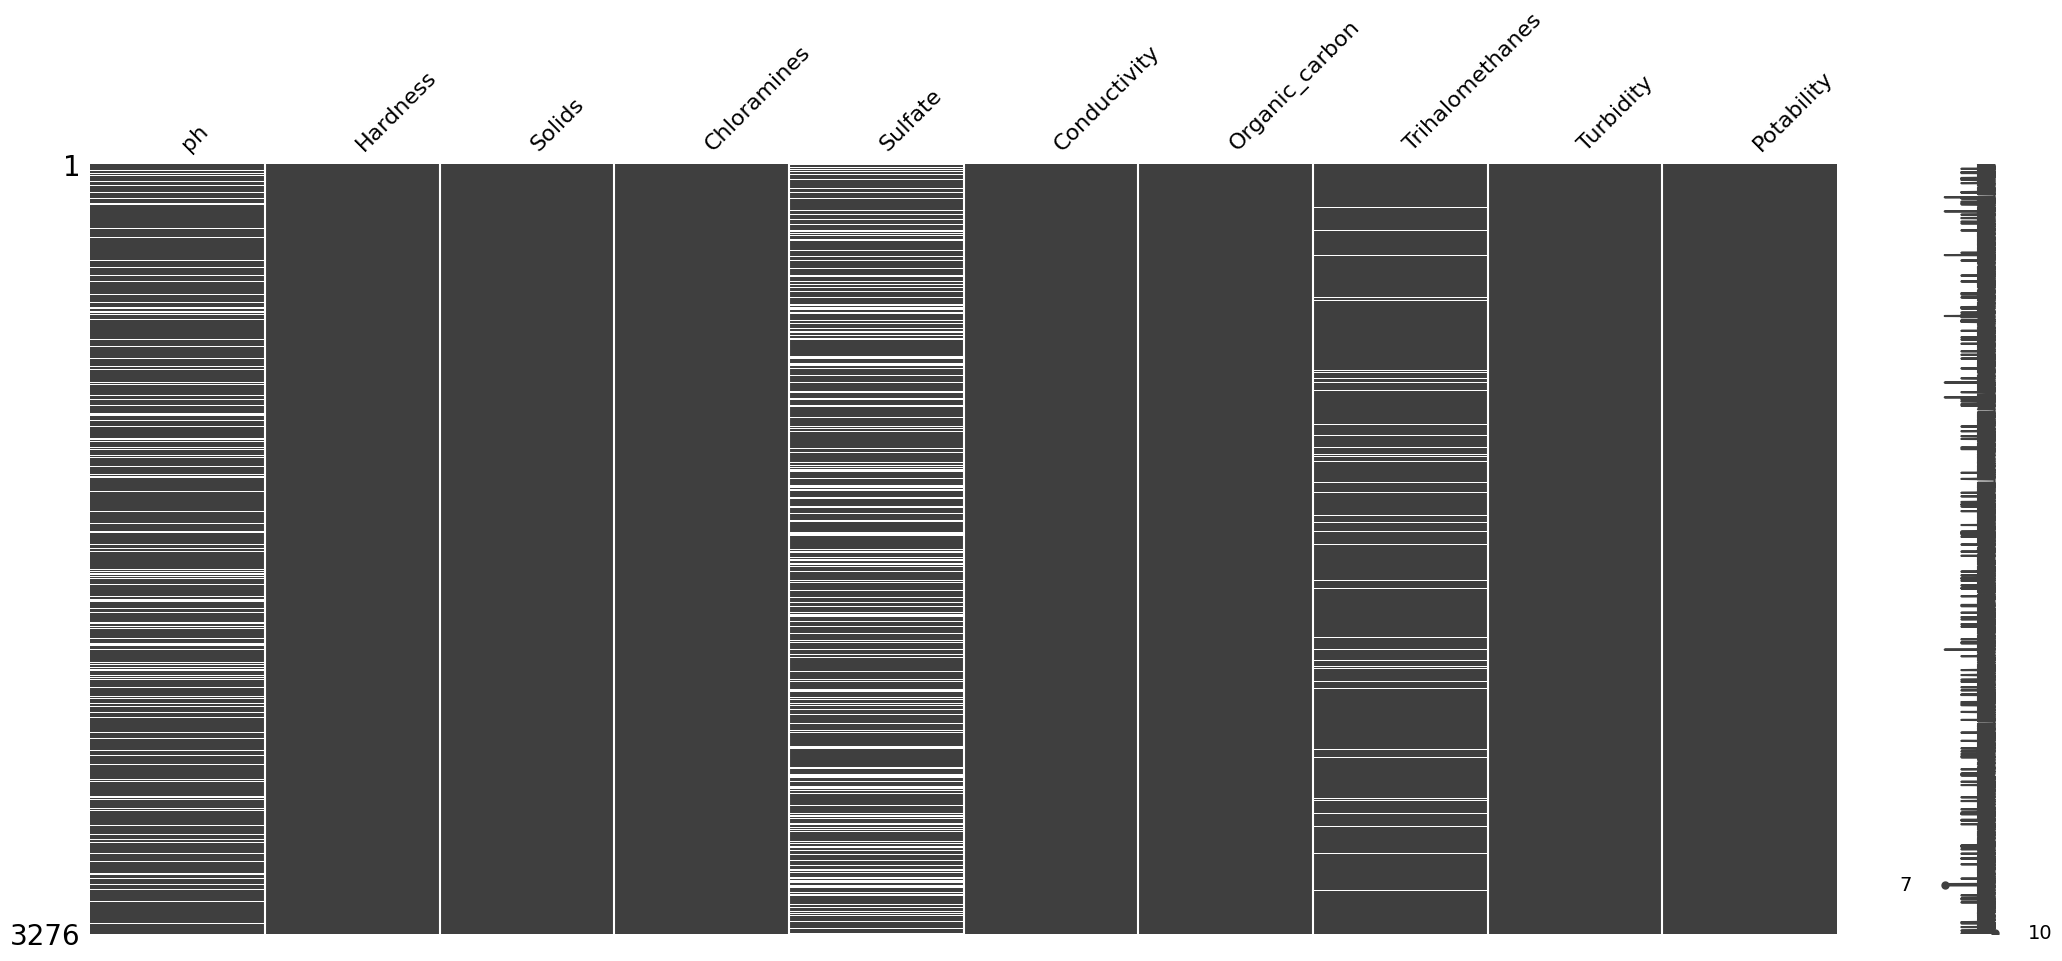

In [ ]:
msno.matrix(df)
plt.show()

In [ ]:
df.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
df["ph"].fillna(value = df["ph"].mean(), inplace = True)
df["Sulfate"].fillna(value = df["Sulfate"].mean(), inplace = True)
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].mean(), inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
df.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Axes: >

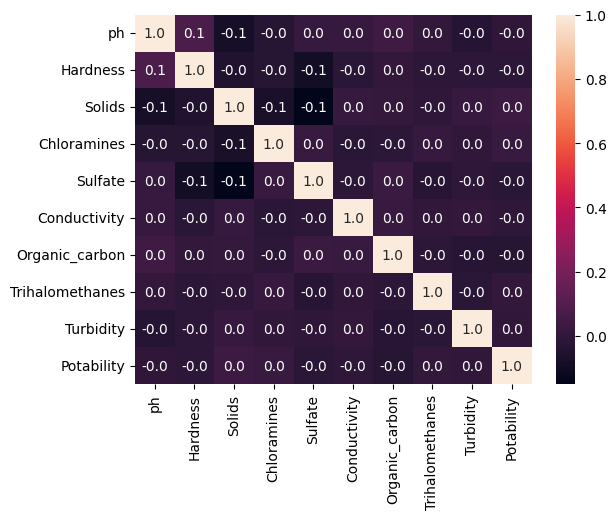

In [ ]:
sns.heatmap(df.corr(), annot = True,fmt='.1f')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



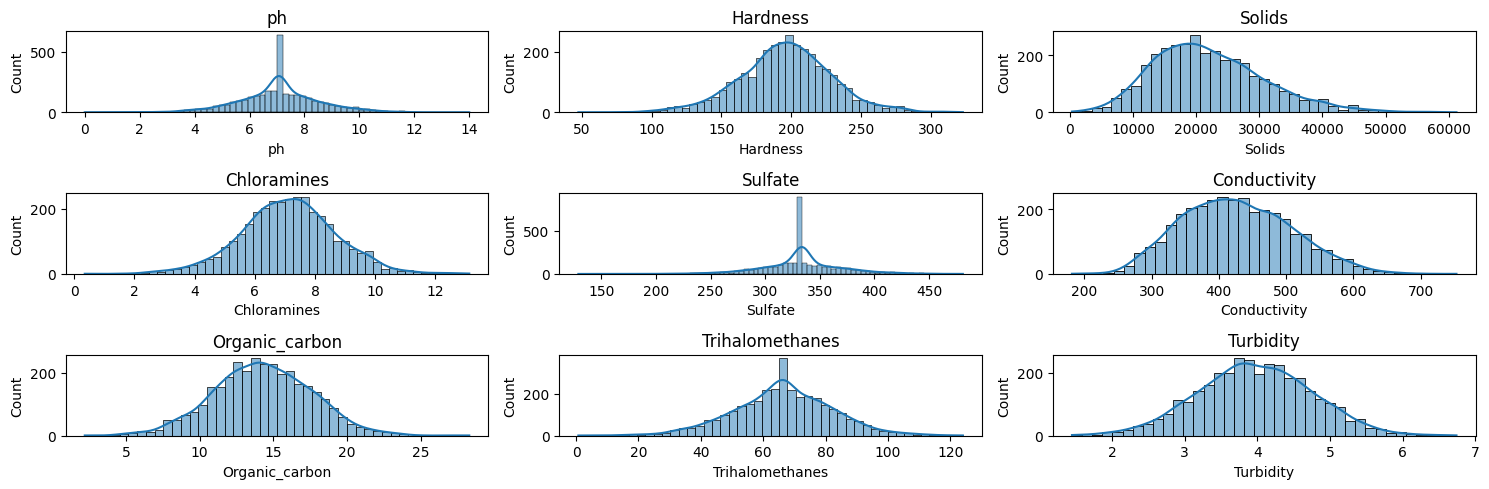

In [ ]:
show_distributions(df.columns[:-1], df,3,3)

In [ ]:
X =  df.drop("Potability",axis=1).values
y=   df['Potability'].values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Preprocessing: Train-Test Split and Normalization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print("x - train shape:",X_train.shape)
print("x - test shape:",X_test.shape)
print("y - train shape:",y_train.shape)
print("y - test shape:",y_test.shape)

x - train shape: (2194, 9)
x - test shape: (1082, 9)
y - train shape: (2194,)
y - test shape: (1082,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# min-max normalization
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)
X_train = (X_train - x_train_min)/(x_train_max-x_train_min)
X_test = (X_test - x_train_min)/(x_train_max-x_train_min)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Modelling: Decision Tree and Random Forest Classifiers

In [ ]:
models = [("DTC", DecisionTreeClassifier(max_depth = 3)),
          ("RF",RandomForestClassifier())]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
finalResults = []
cmList = []
for name, model in models:
    model.fit(X_train, y_train) # train
    model_result = model.predict(X_test) # prediction
    score = precision_score(y_test, model_result)
    cm = confusion_matrix(y_test, model_result)

    finalResults.append((name, score))
    cmList.append((name, cm))
finalResults

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[('DTC', 0.6875), ('RF', 0.6923076923076923)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



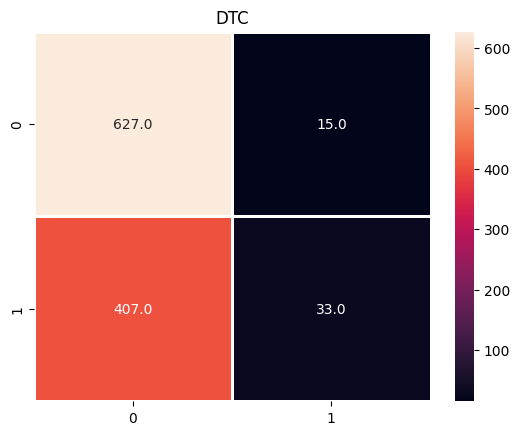

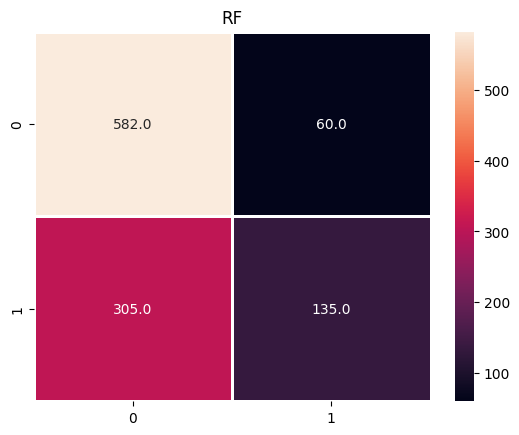

In [ ]:
for name, i in cmList:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.8, fmt = ".1f")
    plt.title(name)
    plt.show()

Visualize Decision Tree

In [ ]:
dt_clf = models[0][1]
dt_clf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



DecisionTreeClassifier(max_depth=3)

In [ ]:
# tree.plot_tree() has "feature_names" parameter. This parameter uses a list
df.columns.tolist()[:-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



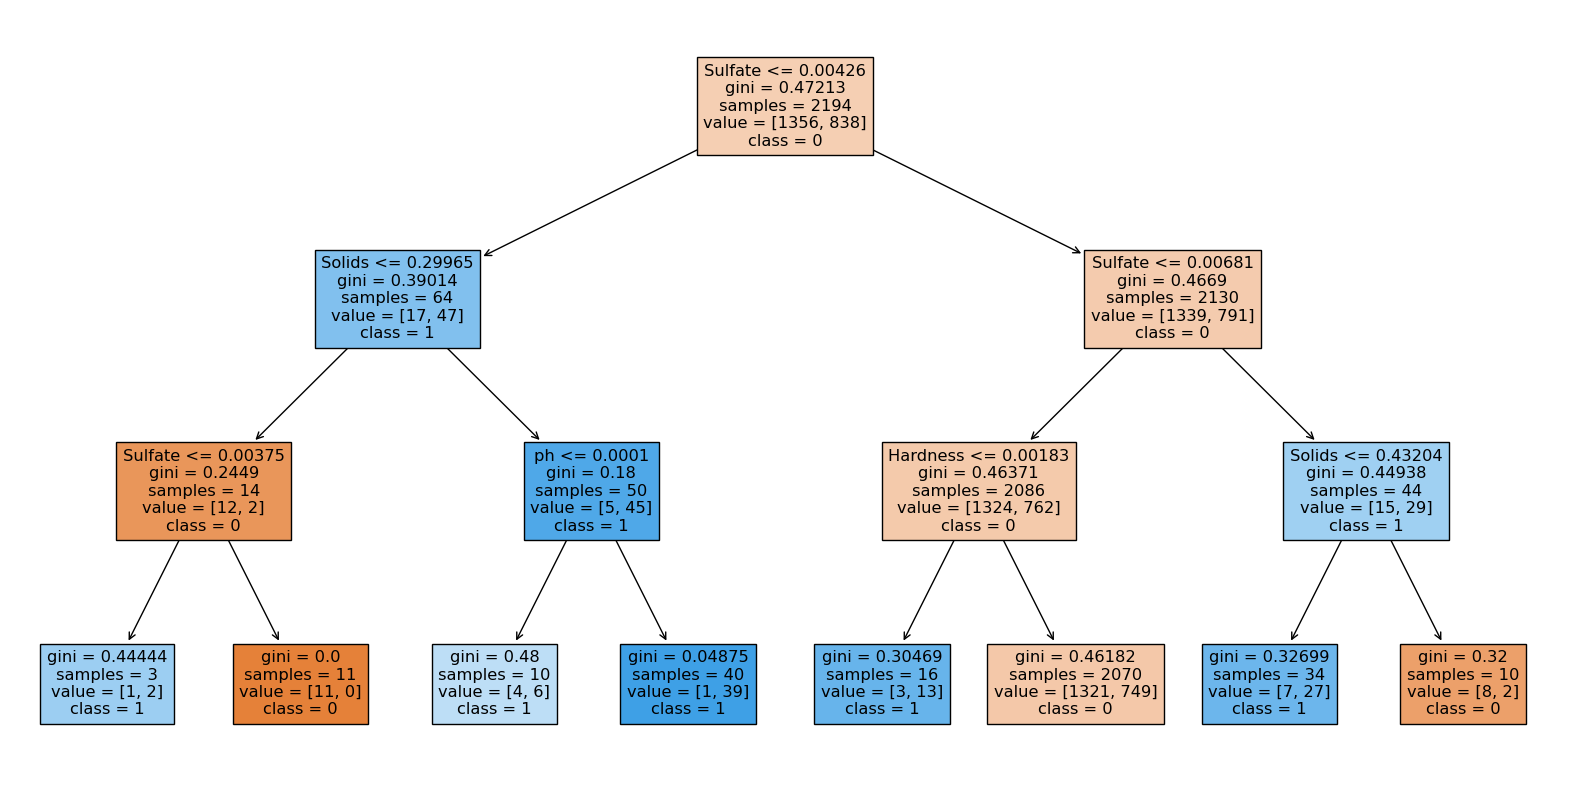

In [ ]:
plt.figure(figsize = (20,10))
tree.plot_tree(dt_clf,
               feature_names =  df.columns.tolist()[:-1],
               class_names = ["0", "1"],
               filled = True,
               precision = 5)
plt.show()

Random Forest Hyperparameter Tuning

In [ ]:
model_params = {
    "Random Forest":
    {
        "model": RandomForestClassifier(),
        "params":
        {
            "n_estimators": [10, 50, 100],
            "max_features": ["sqrt", "log2"],
            "max_depth": list(range(1, 21, 3))
        }
    }
}

model_params

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'Random Forest': {'model': RandomForestClassifier(),
  'params': {'n_estimators': [10, 50, 100],
   'max_features': ['sqrt', 'log2'],
   'max_depth': [1, 4, 7, 10, 13, 16, 19]}}}

In [ ]:
# Cross Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

scores = []

for model_name, params in model_params.items():
    rs = RandomizedSearchCV(params["model"], params["params"], cv=cv, n_iter=10)
    rs.fit(X, y)
    scores.append([model_name, dict(rs.best_params_), rs.best_score_])

scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[['Random Forest',
  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 16},
  0.6733794917147645]]

Re-Modelling

In [ ]:
# Defining best parameters and modelling again
best_params = {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 16}

new_model = RandomForestClassifier(**best_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
new_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



RandomForestClassifier(max_depth=16, max_features='log2')

In [ ]:
new_model_result = new_model.predict(X_test)
new_score = precision_score(y_test, new_model_result)

print("New Precision Score: ", new_score)

New Precision Score:  0.6910112359550562


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Visualizing 2 Decision Tree

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



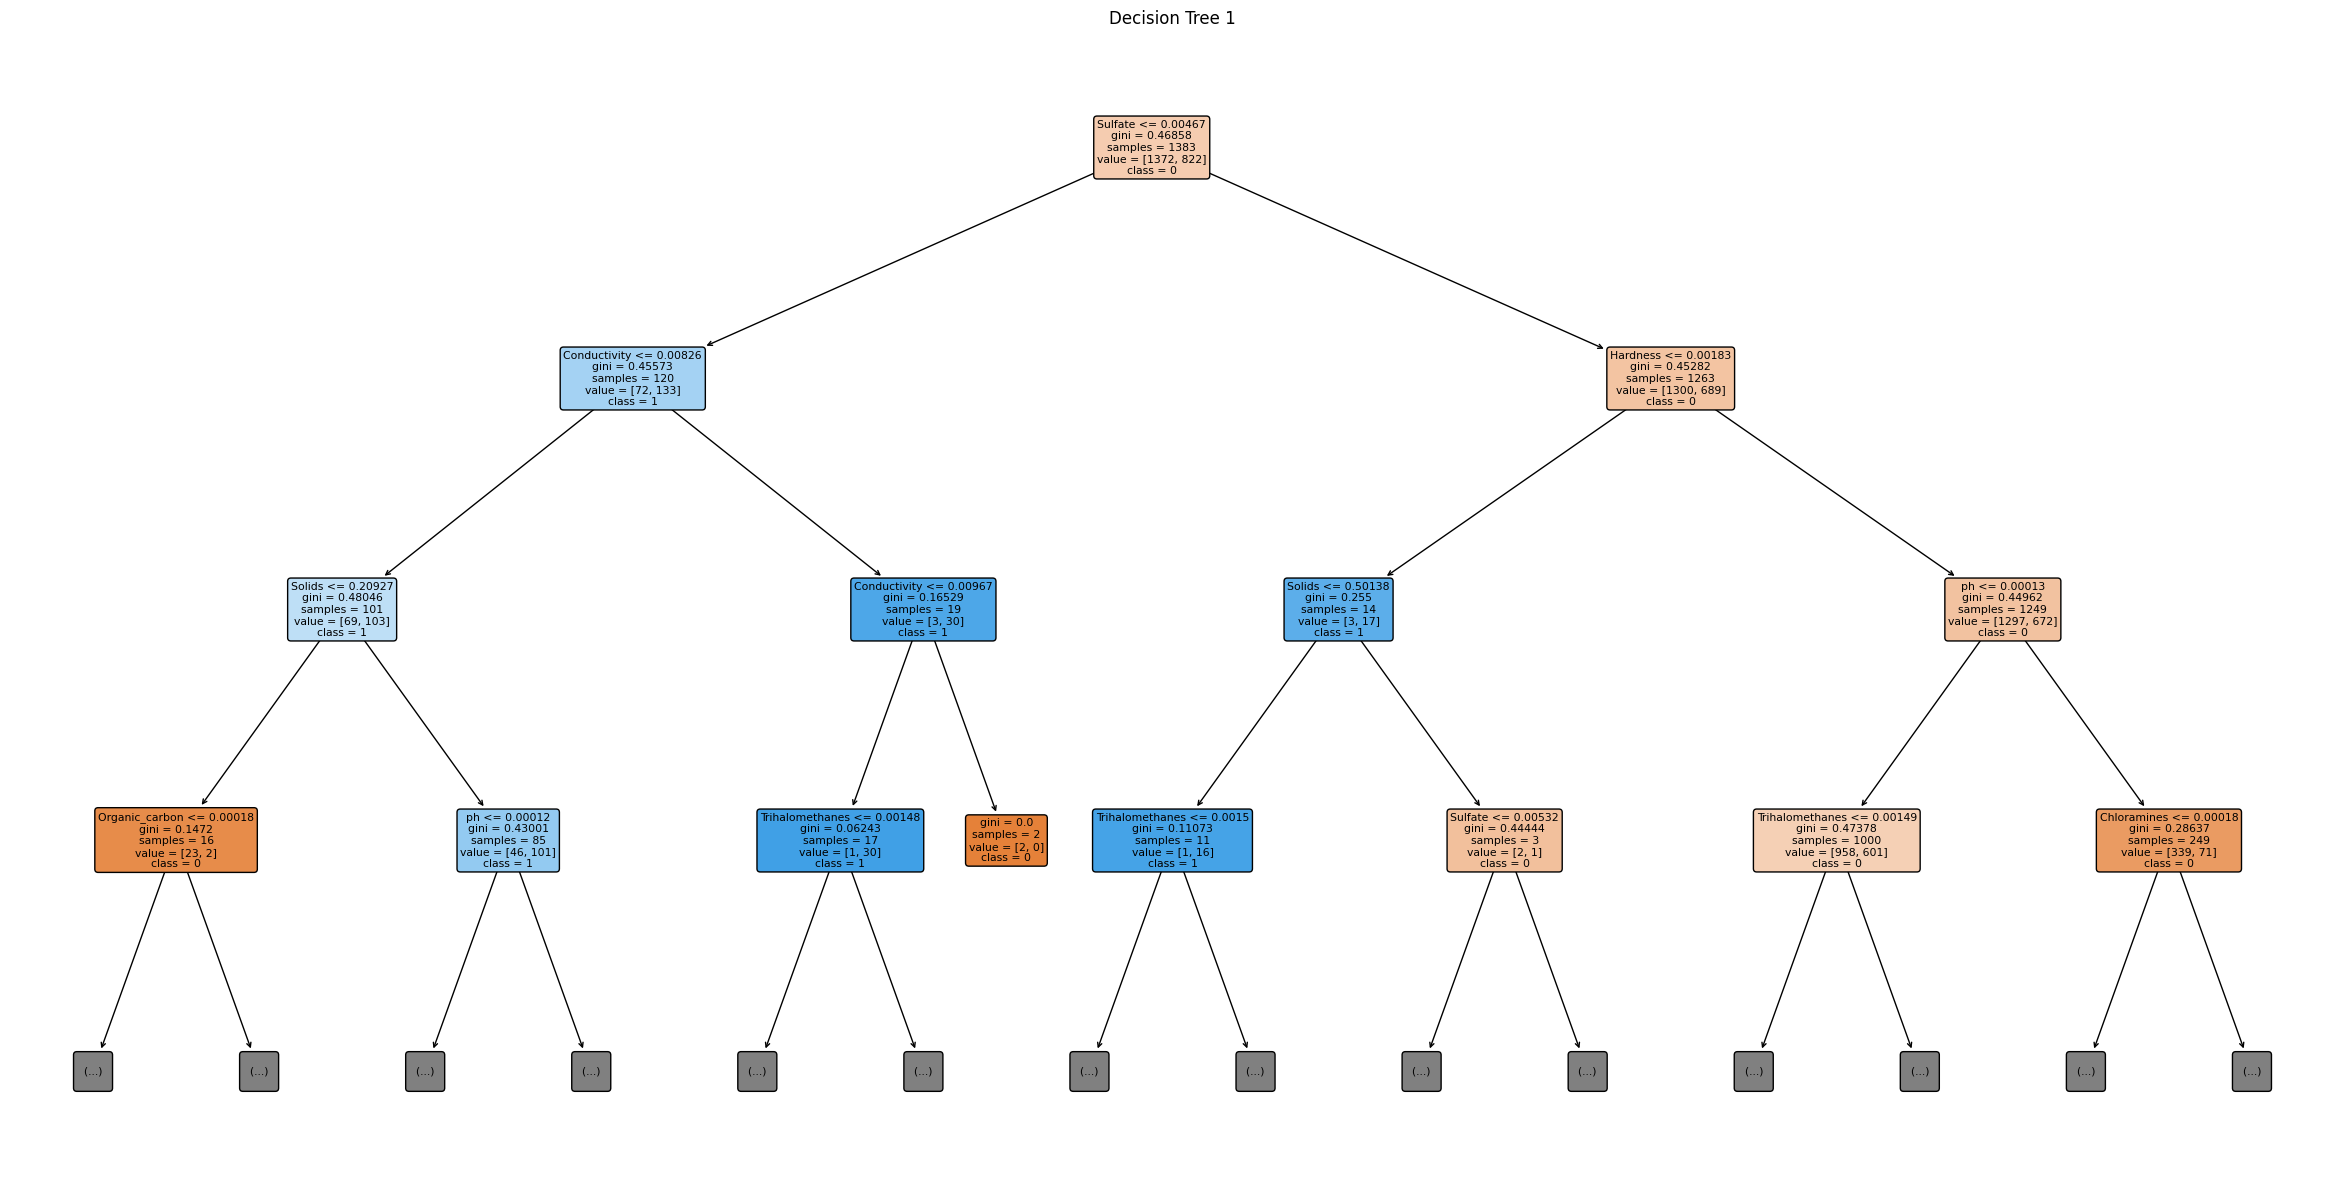

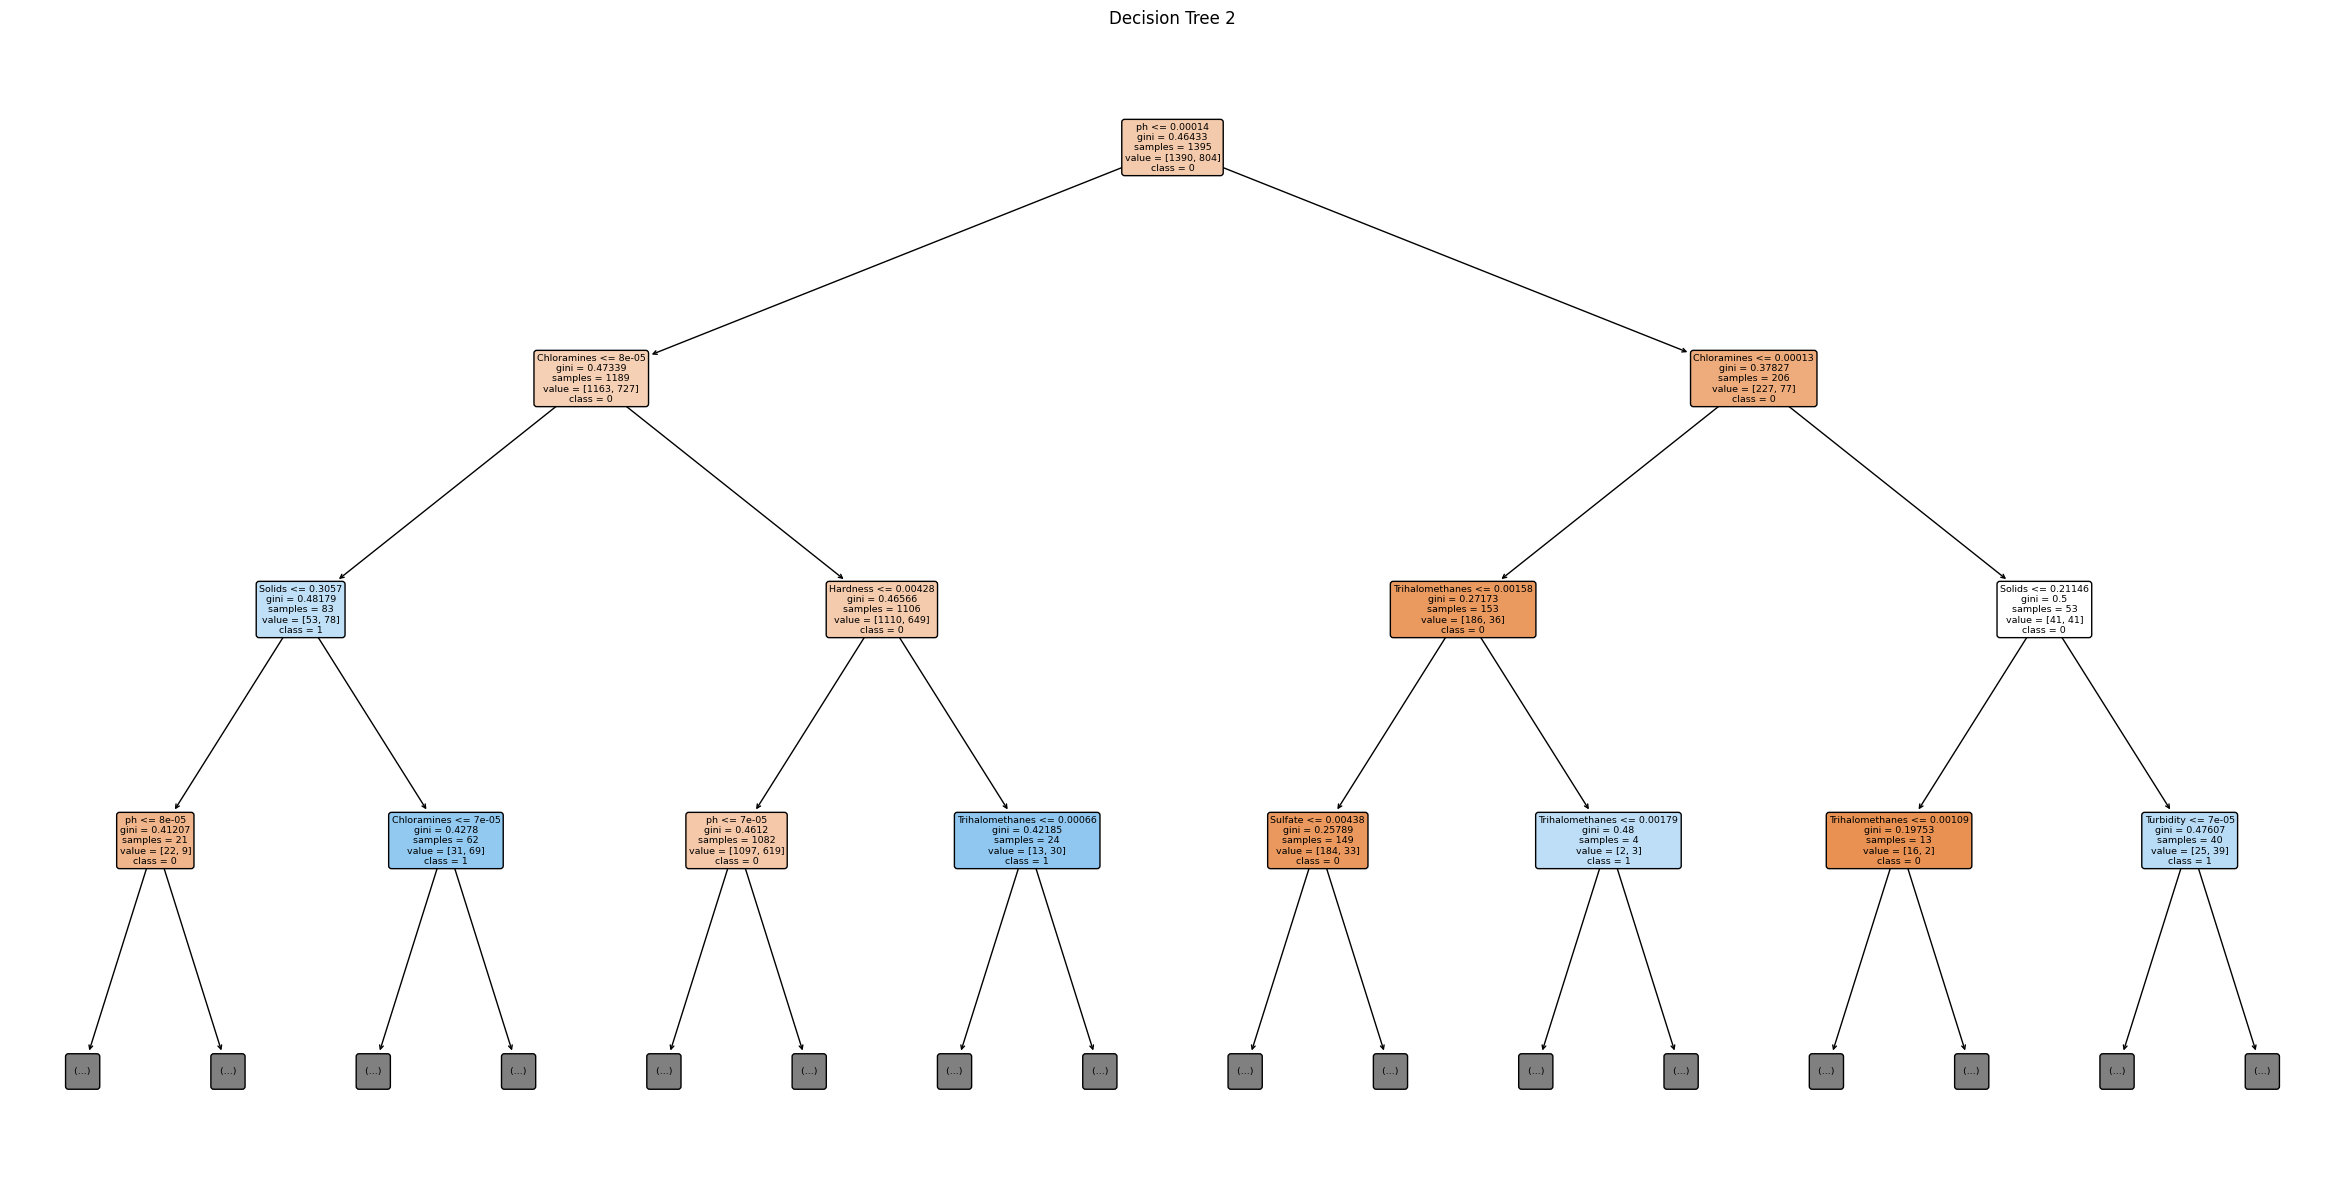

In [ ]:
rf_clf = models[1][1]

# Calculate precision scores for all trees
bonus_scores = []

for estimator in rf_clf.estimators_:
    model_result = estimator.predict(X_test)
    score = precision_score(y_test, model_result)
    bonus_scores.append(score)

# Get indices of top 2 trees with highest precision scores
top_2_indices = np.argsort(bonus_scores)[-2:]

# Visualize the top 2 trees with precision scores
for i, index in enumerate(top_2_indices):
    plt.figure(figsize=(30, 15))

    tree.plot_tree(decision_tree=rf_clf.estimators_[index],
                   feature_names=df.columns.tolist()[:-1],
                   class_names=["0", "1"],
                   filled=True,
                   rounded=True,
                   precision=5,
                   max_depth=3)

    plt.title(f"Decision Tree {i+1}")
    plt.show()